# About thsi file...

Has four sections:
## 1. Unique image in submission data
Uses PCA + clustering(Eigen faces) for identifying unique pictures in the dataset

## 2. Data augmentation
Techniques we have used to augment the data

## 3. Image centering
Techniques we have used to center the image

## 4. Inconsitent landmarks
Observations about the data where the landmarks are marked differently between images

# Setup

In [1]:
import os
import sys
import pickle
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd drive/MyDrive/Colab\ Notebooks/cct
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/cct


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from modules.source_data import SourceData

# 1. Unique images in submission(test) set

In [4]:
# Set this to debug mode for quick analysis
debug = True

# Source the data here
centering_params = {}
sd = SourceData(debug=debug, center_params=centering_params)

# 1. Test data
test_data = sd.source_test_csv()
test_data = np.vstack([x.flatten() for x in test_data.X.values])

Preprocessing submission data


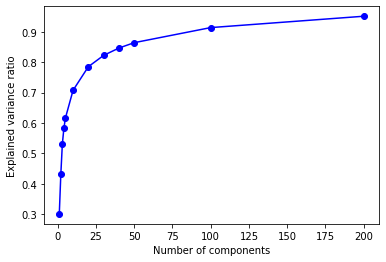

In [6]:
def pcas(x_data, kvals):
    """
    Performs PCA with x_data for different values for number of components
    :param x_data: X data for the PCA
    :param kvals: List or asingle value of 'k'
    """
    
    # If kvals is not an iterable make it one
    try:
        kvals = [x for x in kvals]
    except TypeError:
        kvals = [kvals, ]
    
    explained_variance = []
    # Perform the PCA and collect the variance for each scenario
    for k in kvals:
        pca = PCA(n_components=k)
        new_x = pca.fit_transform(x_data)
        explained_variance.append(np.sum(pca.explained_variance_ratio_))
    
    # It it is a single value then do not return as a list
    # Also return the fit pca 
    if len(explained_variance) == 1:
        return pca, new_x
    else:
        return explained_variance

def optimal_features():

    # These are the kvals to calculate the 
    kvals = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]
    
    # Performs PCA's for each n_components 
    explained_variance = pcas(test_data, kvals)
    
    # Create a line plot for the explained variance
    plt.plot(kvals, explained_variance, '-o', color= 'b')
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    plt.show()

optimal_features()

In [7]:
def dbscan(x_data, eps=0.5, min_samples=5):
    
    # Find the clusters in the data
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(x_data)
    
    # 
    labels, counts = np.unique(db.labels_, return_counts=True)
    
    index = np.argsort(counts)
    return db.labels_, labels[index], counts[index]

In [8]:
def density_grouping(data, kvals=50, clean_threshold=0.03, min_samples=100):

  # These are the number of images that we are willing to throw away
  threshold = data.shape[0] * clean_threshold

  # Fit and transform the x data
  pca, transformed_x = pcas(data, kvals=kvals)

  for eps in np.linspace(17, 20, 20):
    print('Evaluating kvals %d eps %d' % (kvals, eps))

    # Find the labels with 8 groups
    labels, ulabels, counts = dbscan(transformed_x, eps, min_samples)

    # These are the ungroupables
    ungroupables = counts[ulabels==-1][0]
    ungroupable_label = -1

    if ungroupables > threshold :
      print('Ungroupables are %d' % ungroupables)
      continue

    # Next plot the ungroup-ables
    num_ys = 10
    num_xs = round(ungroupables/num_ys + 0.5)
    print(num_xs)

    fig, axs = plt.subplots(num_xs, num_ys, figsize=(15,15*(num_xs/num_ys)))
    index = np.where(labels == -1)[0]

    cnt = 0
    for x in range(num_xs):
      for y in range(num_ys):
        try:
          idx = index[cnt]
          axs[x, y].imshow(data[idx, :].reshape(96, 96), cmap='bone')
          axs[x, y].axis('off')
          axs[x, y].set_title(str(idx))
          cnt += 1
        except IndexError:
          continue
    plt.show()

    return index


In [9]:
kvals = 50
clean_threshold = 0.03
min_samples = 100

Evaluating kvals 50 eps 17
Ungroupables are 152
Evaluating kvals 50 eps 17
Ungroupables are 135
Evaluating kvals 50 eps 17
Ungroupables are 121
Evaluating kvals 50 eps 17
Ungroupables are 106
Evaluating kvals 50 eps 17
Ungroupables are 96
Evaluating kvals 50 eps 17
Ungroupables are 82
Evaluating kvals 50 eps 17
Ungroupables are 71
Evaluating kvals 50 eps 18
Ungroupables are 65
Evaluating kvals 50 eps 18
Ungroupables are 59
Evaluating kvals 50 eps 18
Ungroupables are 55
Evaluating kvals 50 eps 18
6


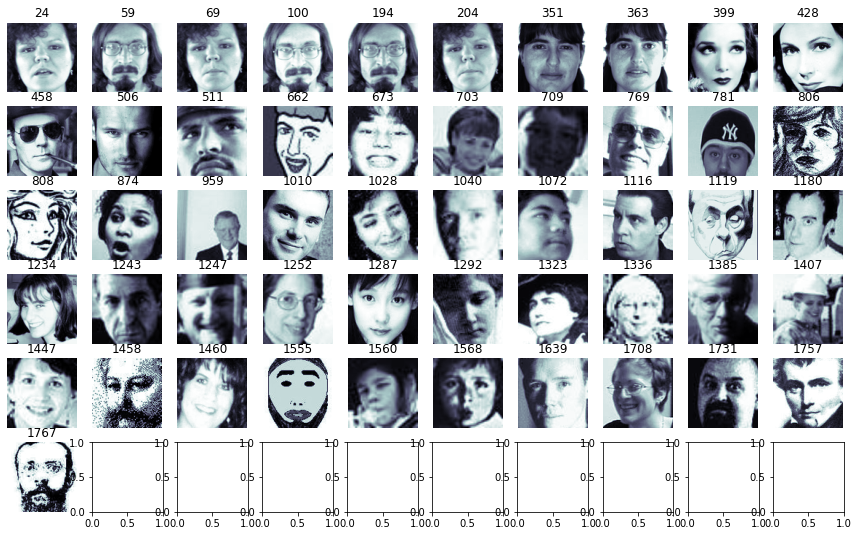

In [10]:
index = density_grouping(test_data, kvals=kvals, clean_threshold=clean_threshold, min_samples=min_samples)
filename = 'data/analysis/test_quirky.p'
with open(filename ,'wb') as outfi:
  pickle.dump(index, outfi)

# 2. Edge detection for creating cartoon like images

In [11]:
import cv2

In [12]:
def edge_mask(img, line_size, blur_value):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_blur = cv2.medianBlur(gray, blur_value)
  edges = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, line_size, blur_value)
  return edges

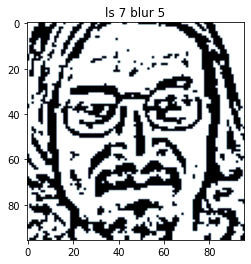

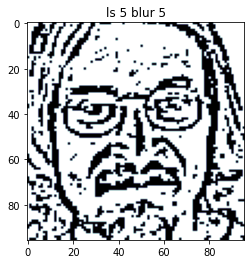

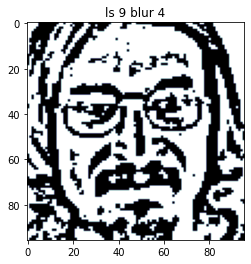

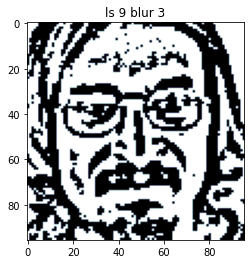

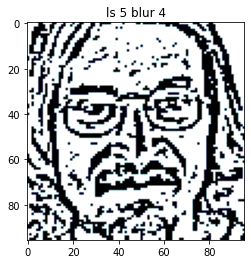

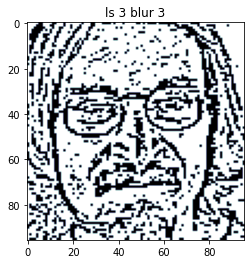

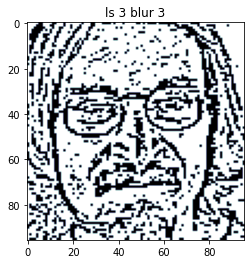

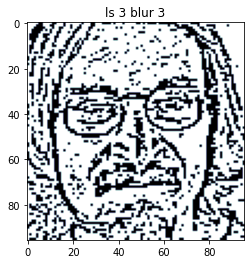

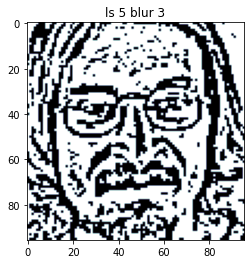

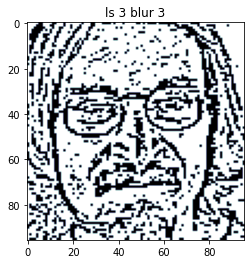

In [14]:
import random

for _ in range(10):
  line_size = random.randint(3, 9)
  if line_size % 2 == 0:
    line_size += 1

  blur_value = random.randint(3, 7)

  if blur_value > line_size:
    blur_value = line_size

  # gray_blur = cv2.medianBlur(train_data[2940, :].reshape(96, 96), blur_value)
  img = test_data[17, :].reshape(96, 96) * 255
  img = img.astype('uint8')
  edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, line_size, blur_value)
  plt.imshow(edges, cmap='bone')
  plt.title('ls %d blur %d' % (line_size, blur_value))
  plt.show()

# 3. Data Augmentation

In [69]:
import os
import cv2
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.transforms import warp
from modules.transforms import affine_transform
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


class AugmentData:
    def __init__(self, max_rotation=10, max_shift=10, max_shear=0.2, max_scale=0.2, num_transforms=2,
                 colab_compatibility=True, elastic_alpha=34, elastic_sigma=4, cartoon_prob=0,
                 elastic_prob=0.5):
        """
        :param max_rotation: Maximum angle to rotate the image by.
                            Actual Rotation will be random number in the interval (-max_rotation, max_rotation)
        :param max_shift: Maximum lateral shift of the image
                          Actual shift will be in the interval (-max_shift, max_shift)
        :param max_shear: Maximum shear angle for the image.
                          Actual shear will be in the interval (-max_shear, max_shear)
        :param max_scale: Maximum scale for the image. Must be between 0 and 1
                          Actual scale will be in the interval (1-max_scale, 1+max_scale)
        :param num_transforms:  Number of random transforms to perform
        :param colab_compatibility: Create a Google colab compatible scales value?
        :param elastic_sigma: sigma to use for the elastic transformation
        :param elastic_alpha: alpha to use for the elastic tarnsformation
        :param cartoon_prob: What fraction of images were cartoon
        :param elastic_prob: What fraction of images were deformed
        """
        self.data = None
        self.max_rotation = max_rotation
        self.max_shift = max_shift
        self.max_shear = max_shear
        self.max_scale = max_scale
        self.num_transforms = num_transforms
        self.mode = "edge"
        self.do_plots = True
        self.colab_compatibility = colab_compatibility
        self.elastic_alpha = elastic_alpha
        self.elastic_sigma = elastic_sigma

        self.elastic_prob = elastic_prob
        self.cartoon_prob = cartoon_prob
        self.cartoon_line_size = (3, 7)
        self.cartoon_blur_value = (3, 7)

    def augment(self, data, force_create=False):
        """
        Transform all the images in the input DataFrame

        :param data: Dictionary of data for each response
        :param force_create: Force the creation of the augment file
        """

        outfile = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                               '../data/augment/augment_data_%d.p' % self.num_transforms)

        if not force_create:
            try:
                # Check to see if train, cv, test data already exists
                with open(outfile, 'rb') as infi:
                    augmented_data = pickle.load(infi)
                print('Already augmented data was found, delete the file if you want to recreate')
                return augmented_data
            except FileNotFoundError:
                pass

        # This object will take no memory if it just returns the file
        self.data = data

        # For each response create the transformed matrices
        all_transformed_data = {}
        for response_name, data_df in self.data.items():
            # Accumulated DataFrame
            all_transformed_data[response_name] = self.augment_one(data_df, response_name)

        # Check to see if train, cv, test data already exists
        with open(outfile, 'wb') as outfi:
            pickle.dump(all_transformed_data, outfi)

        return all_transformed_data

    def augment_one(self, data_df, response_name, do_one=False, force_create=False):
        """
        Transform all the images in the input DataFrame

        :param data_df: Dictionary of data for each response
        :param response_name:
        :param do_one: Do only one transformation of the image?
        :param force_create:
        """

        # These are the only two columns that augment is expecting
        data_df = data_df[['X', 'y']]

        # If 0 transformation then return the original DataFrame
        if self.num_transforms == 0:
            return data_df

        # This is the augmented data with the
        outfile = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                               '../data/augment/augdat_resp_%s_samples_%d.p' % (response_name, self.num_transforms))

        if not do_one and not force_create:
            try:
                # Check to see if train, cv, test data already exists
                with open(outfile, 'rb') as infi:
                    augmented_data = pickle.load(infi)
                print('Augmented data found for response %s with transforms %d and has %d samples input data as %d rows'
                      % (response_name, self.num_transforms, augmented_data.shape[0], data_df.shape[0]))
                return augmented_data
            except FileNotFoundError:
                pass

        print('Augmenting response %s' % response_name)
        plt_cnt = 0
        # If the image has a left or right characteristic then flipping it changes the landmark.
        if 'left' in response_name or 'right' in response_name:
            create_flip = False
        else:
            create_flip = True

        # All the transformations are by-image, do loop thorugh each image
        accum_df = pd.DataFrame()
        for row in range(data_df.shape[0]):
            image_x = data_df.iloc[row]['X']
            coord_y = data_df.iloc[row]['y']

            # affine transformation
            data_row_transform = self.transform_img(image_x, coord_y.copy(), create_flip)
            try:
                # Keep only the columns that are in the input DataFrame
                tmp_df = data_row_transform[[x for x in data_df.columns]]
            except KeyError:
                # This occurs when the transformations led to empty DataFrame
                # In this case skip this DataFrame
                continue

            accum_df = pd.concat((accum_df, tmp_df))
            data_row_transform.assign(parent=pd.Series([row for _ in range(data_row_transform.shape[0])]))
            if self.do_plots and plt_cnt < 1 and not data_row_transform.empty:
                # Produce five plots per response type
                self.plot_transformations(image_x, coord_y, data_row_transform, response_name)
                plt_cnt += 1

            if do_one:
                break

        # The return DataFrame, shuffle the rows to remove correlation in batches
        return_df = pd.concat((data_df, accum_df))
        return_df = return_df.sample(frac=1).reset_index(drop=True)

        if not do_one:
            # Check to see if train, cv, test data already exists
            with open(outfile, 'wb') as outfi:
                pickle.dump(return_df, outfi)

        return return_df

    @staticmethod
    def elastic_transform(image, alpha, sigma, random_gen=None):
        """
        Perform an elastic transformation of the image
        # Motivated by this code: https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a

        :param image: Image to transform
        :param alpha: Alpha value for transformation (original value used 34)
        :param sigma: Sigma value for transformation (original value used 34)
        :param random_gen:
        :return:
        """

        # A random state creates a random number generator without existing with than existing one
        if random_gen is None:
            random_gen = np.random.RandomState(None)
        else:
            random_gen = np.random.RandomState(random_gen)

        # Create an x shift and y shift value for every pixel in the image
        shape = image.shape
        dx = gaussian_filter((random_gen.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_gen.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        # This is the original pixel location of the image
        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        # We add a delta to it
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        # And map it to the new location
        return map_coordinates(image, indices, order=1).reshape(shape)

    @staticmethod
    def cartoon(image, line_size, blur_value):
        """
        Convert the image into a cartoon using edge detection
        :param image: Image to transform
        :param line_size: Thickness of the resulting edge line
        :param blur_value: Blur the lines using how many pixels?
        :return:
        """

        # gray_blur = cv2.medianBlur(train_data[2940, :].reshape(96, 96), blur_value)
        image = image * 255
        image = image.astype('uint8')
        edges = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, line_size, blur_value)
        edges = edges.astype('float32')/255

        return edges

    @staticmethod
    def _pixel_spread(coord, limits):
        """
        Spread the value of the pixel across multiple
        :param coord: X or y coordinate
        :param limits: Maximum limits each value can take
        :return:
        """

        # col = round(coord_y[1])
        # col = 0 if col < 0 else col
        # col = image_x.shape[1] - 1 if col > image_x.shape[1] - 1 else col
        axis = int(coord)

        # This is the value that got rounded off
        remainder = coord - axis

        # Remainder can only be greater than 0
        axis1 = axis + 1
        remainder = remainder / axis1

        print('Axis %d axis1 %d remainder %.2f' % (axis, axis1, remainder))
        if limits[0] < axis < limits[1] and limits[0] < axis1 < limits[1]:
            return (axis, 1), (axis1, remainder)
        else:
            return None

    def spread_pixel(self, image_x, coord_y):
        # Create an array of zeros the same shape as the image
        # Mark it with a one as to where we want it to transform
        # Note that X are columns and Y's are rows and hence this flip
        trans_im_y = np.zeros(image_x.shape)
        cols = self._pixel_spread(coord_y[1], (0, image_x.shape[1]))

        # As we are rounding the values, perhaps we can spread it over two pixels in teh ratio of the rounding
        # For example the value of 73.3 can be thought of as 73 + a74, rearranging a = (73.3-73)/74= 0.3/74
        rows = self._pixel_spread(coord_y[0], (0, image_x.shape[0]))

        if cols is None or rows is None:
            return None

        #
        for col, valc in cols:
            for row, valr in rows:
                trans_im_y[col, row] = valc * valr
                print('Col %d row %d value %.2f' % (col, row, trans_im_y[col, row]))

        return trans_im_y

    @staticmethod
    def one_pixel(image_x, coord_y):
        # Create an array of zeros the same shape as the image
        # Mark it with a one as to where we want it to transform
        # Note that X are columns and Y's are rows and hence this flip
        trans_im_y = np.zeros(image_x.shape)

        col = round(coord_y[1])
        if col > image_x.shape[1] - 1:
            return None

        row = round(coord_y[0])
        if row > image_x.shape[0] - 1:
            return None

        #
        trans_im_y[row, col] = 1

        return trans_im_y

    def do_cartoon(self, image_x, coord_y, all_transformations, do_debug_plots):
        """

        :param image_x:
        :param coord_y:
        :param all_transformations:
        :param do_debug_plots:
        :return:
        """

        for _ in range(self.num_transforms):
            line_size = random.randint(*self.cartoon_line_size)
            blur_value = random.randint(self.cartoon_blur_value[0], line_size)

            if line_size % 2 == 0:
                line_size += 1

            if blur_value > line_size:
                blur_value = line_size

            trans_x = self.cartoon(image_x, line_size=line_size, blur_value=blur_value)
            if do_debug_plots:
                plt.figure()
                plt.imshow(trans_x, cmap='bone')
                plt.plot(coord_y[0], coord_y[1], 'o')
                plt.title('Line size %d blur %d' % (line_size, blur_value))
                plt.show()

            all_transformations.append({'X': trans_x, 'y': coord_y, 'shear': 0, 'translation': 0, 'rotation': 0,
                                        'scale': 0})
        # Convert it into a DataFrame
        return pd.DataFrame(all_transformations)

    def transform_img(self, image_x, coord_y, create_flip=False, do_debug_plots=False):
        """
        :param image_x: The x image to be transformed
        :param coord_y: The y coordinates to be transformed
        :param create_flip: Whether to create flipped images or not
        :param do_debug_plots: Create debug plots or not
        """
        do_debug_plots = do_debug_plots

        all_transformations = []
        # Just cartoon transform some of the images
        if random.random() < self.cartoon_prob:
            # Make all these transformation into cartoons
            return self.do_cartoon(image_x, coord_y, all_transformations, do_debug_plots)

        # All the scale transformation we will do to this image
        # If the random number is zero then we get a scaling of 1 - self.max_scale
        # If the random number is 1 then we get a scaling of self.max_scale - 2*self.max_scale = -self.max_scale
        scales = [1 + (self.max_scale - 2*random.random()*self.max_scale) for _ in range(self.num_transforms)]

        # The version in Google colab expects a tuple of sx and sy
        if self.colab_compatibility:
            scales = [(x, x) for x in scales]

        # All the rotations we will do to this image
        # If the random number is zero then we get a scaling of self.max_rotation
        # If the random number is 1 then rotation is self.max_rotation - 2*self.max_rotation = -self.max_rotation
        rotations = [self.max_rotation - 2 * random.random() * self.max_rotation for _ in range(self.num_transforms)]

        # All the translations we will do to this image
        # Translation is basically a shift in the x and y direction
        translations_x = [self.max_shift - 2 * random.random() * self.max_shift for _ in range(self.num_transforms)]
        translations_y = [self.max_shift - 2 * random.random() * self.max_shift for _ in range(self.num_transforms)]
        translations = [x for x in zip(translations_x, translations_y)]

        # All the translations we will do to this image
        shears = [self.max_shear - 2 * random.random() * self.max_shear for _ in range(self.num_transforms)]

        # Flip or not
        if create_flip:
            # Half the images have a possibility of being flipped
            flips = [random.random() > 0.5 for _ in range(self.num_transforms)]
        else:
            # Can't flip, it changes the landmark
            flips = [0 for _ in range(self.num_transforms)]

        # Elastic transform
        elastics = [random.random() < self.elastic_prob for _ in range(self.num_transforms)]

        for scale, rotation, translation, shear, flip, elastic in \
                zip(scales, rotations, translations, shears, flips, elastics):
            # Create an object for the transformation
            # Perform the transformation
            trans_x, forward_matrix, _ = affine_transform(
                image_x.copy(), scale=scale, rotation=np.deg2rad(rotation), translation=translation,
                shear=np.deg2rad(shear))

            # Now convert the coordinates
            trans_y = warp(forward_matrix, coord_y)

            # Translate the coordinates into an image for
            # trans_im_y = self.spread_pixel(trans_x, trans_y)
            trans_im_y = self.one_pixel(trans_x, trans_y)
            if trans_im_y is None:
                continue

            # Elastic transformation of the image
            if elastic:
                alpha = self.elastic_alpha
                sigma = self.elastic_sigma
                seed = random.randint(1, 65535)

                # noinspection PyTypeChecker
                trans_x = self.elastic_transform(trans_x, alpha, sigma, random_gen=seed)
                # noinspection PyTypeChecker
                t_im_y = self.elastic_transform(trans_im_y, alpha, sigma, random_gen=seed)
            else:
                alpha = 0
                sigma = 0
                t_im_y = trans_im_y

            # Locations where the pixel is now spread
            w_ty = np.where(t_im_y)
            if w_ty[1].size == 0:
                # The coordinates are outside the image, we skip this one
                continue

            # Weighted average of the location that they went to
            do_new_method = False
            if do_new_method:
                # The pixel has spread across multiple locations
                # Take the weighted average of its value across rows
                weights_y = np.sum(t_im_y, axis=1)
                loc_y = np.where(weights_y)
                row = np.sum(loc_y[0]*weights_y[loc_y[0]]/np.sum(weights_y[loc_y[0]]))

                # Take the weighted average of its value across cols
                weights_x = np.sum(t_im_y, axis=0)
                loc_x = np.where(weights_x)
                col = np.sum(loc_x[0] * weights_x[loc_x[0]] / np.sum(weights_x[loc_x[0]]))
                trans_y = [row, col]
            else:
                trans_y = np.array((np.mean(w_ty[0]), np.mean(w_ty[1])))

            if do_debug_plots:
                plt.figure(figsize=(6.4, 4.8))
                plt.imshow(image_x, cmap='bone')
                w_y = np.where(trans_im_y)
                plt.plot(w_y[0], w_y[1], 'd', markersize=3, color='b')
                plt.plot(trans_y[0], trans_y[1], 'o', markersize=3, color='y')
                plt.plot(coord_y[0], coord_y[1], '*', markersize=3, color='g')
                plt.title('Original')
                plt.show()

                plt.figure(figsize=(6.4, 4.8))
                plt.imshow(trans_x, cmap='bone')
                plt.plot(w_ty[0], w_ty[1], 'd', markersize=1, color='b')
                plt.plot(trans_y[0], trans_y[1], 'o', markersize=2, color='y')
                plt.plot(coord_y[0], coord_y[1], '*', markersize=2, color='g')
                # plt.plot(row, col, '+', markersize=3, color='r')

                strng = ''
                if scale[0] != 1 and scale[1] != 1 :
                  strng = 'Scale x %.2f y %.2f ' % (scale[0], scale[1])
                
                if rotation != 0:
                  strng += 'rotation %.2f ' % rotation
                
                if shear != 0:
                  strng += 'shear %.2f \n' % shear
                
                if translation[0] != 1 and translation[1] != 1 :
                  strng += 'translation x %.2f y %.2f ' % (translation[0], translation[1])

                if alpha > 0 and sigma > 0:
                  strng += 'Elastic alpha %.2f ' % alpha
                  strng += 'Elastic sigma %.2f ' % sigma
                
                plt.title(strng)
                plt.show()

            if flip:
                trans_x = np.fliplr(trans_x)
                # Flip the x-coordinate around
                trans_y[0] = trans_x.shape[0] - trans_y[0] - 1

                if do_debug_plots:
                    plt.figure()
                    plt.imshow(trans_x, cmap='bone')
                    plt.plot(w_ty[0], w_ty[1], 'd', markersize=1, color='b')
                    plt.plot(trans_y[0], trans_y[1], 'o', markersize=2, color='y')
                    plt.plot(coord_y[0], coord_y[1], '*', markersize=2, color='g')
                    plt.ylim([0, 3])
                    plt.title('Flipped')
                    plt.show()

            # If the translated coordinated are within the image range then save the image
            # Otherwise throw it out
            all_transformations.append({'X': trans_x, 'y': trans_y, 'shear': shear, 'translation': str(translation),
                                        'rotation': rotation, 'scale': scale})

        return pd.DataFrame(all_transformations)

    @staticmethod
    def plot_transformations(original_image, original_landmark, transformation_df, response_name):
        """

        :param original_image: Original image before transformation
        :param original_landmark: Landmark on the original image
        :param transformation_df: DataFrame with the transformed images
        :param response_name: Nae of teh response that is being plotted
        :return:
        """

        # These are all the transformations
        all_records = transformation_df.to_dict('index')

        # 1. Plot the original image
        num_xs = len(all_records)+1
        fig, axs = plt.subplots(1, len(all_records)+1, figsize=(6.4*num_xs, 6.4))
        axs[0].imshow(original_image, cmap="bone")
        axs[0].plot([original_landmark[0], ], [original_landmark[1], ], 'o', color='r', markersize=2)
        axs[0].axis("off")
        axs[0].set_title(response_name)

        # 2. Plot each of the individual images
        for idx, record in all_records.items():
            axs[idx+1].imshow(record['X'], cmap="bone")
            axs[idx+1].plot([record['y'][0], ], [record['y'][1], ], 'o', color='r', markersize=2)
            axs[idx+1].axis("off")
            axs[idx+1].set_title('Transformation %d' % (idx+1))
        plt.show()

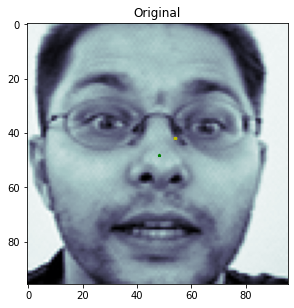

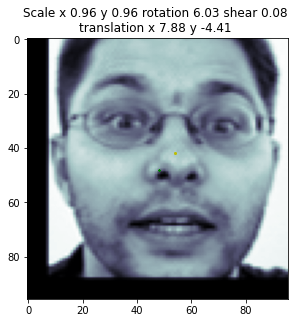

,X,y,shear,translation,rotation,scale
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0669947...","[54.0, 42.0]",0.080978,"(7.881464175523689, -4.410699164483969)",6.02861,"(0.9639467043765686, 0.9639467043765686)"


In [70]:
# Just affine transformation without elastic
augment = AugmentData(max_rotation=10, max_shift=10, max_shear=0.2, max_scale=0.2, colab_compatibility=True, elastic_alpha=34, elastic_sigma=4, cartoon_prob=0, elastic_prob=0, num_transforms=1)
augment.transform_img(test_data[0, :].reshape((96, 96)), np.array([48, 48]), create_flip=False, do_debug_plots=True)

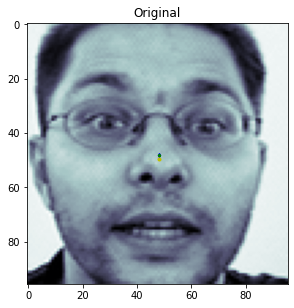

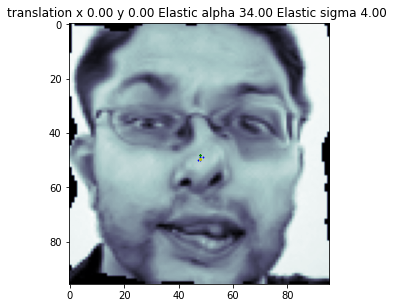

,X,y,shear,translation,rotation,scale
0,"[[0.0, 0.7152488, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[48.0, 49.5]",0.0,"(0.0, 0.0)",0.0,"(1.0, 1.0)"


In [71]:
# Just Elastic
augment = AugmentData(max_rotation=0, max_shift=0, max_shear=0, max_scale=0, colab_compatibility=True, elastic_alpha=34, elastic_sigma=4, cartoon_prob=0, elastic_prob=1, num_transforms=1)
augment.transform_img(test_data[0, :].reshape((96, 96)), np.array([48, 48]), create_flip=False, do_debug_plots=True)

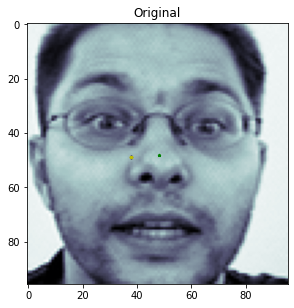

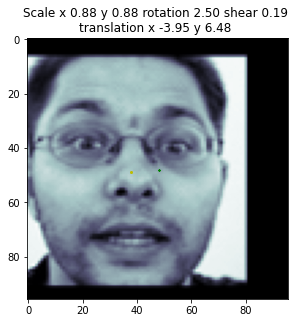

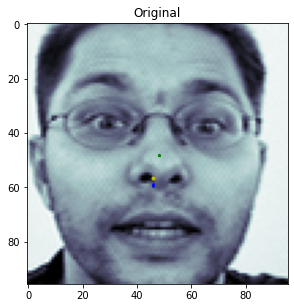

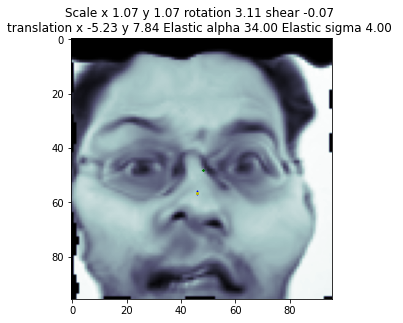

,X,y,shear,translation,rotation,scale
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[38.0, 49.0]",0.193469,"(-3.946876572571954, 6.477482313367398)",2.496386,"(0.8815235306819478, 0.8815235306819478)"
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[46.0, 56.5]",-0.072395,"(-5.229021033956819, 7.841955218884602)",3.114701,"(1.0713851332998332, 1.0713851332998332)"


In [72]:
# Both
augment = AugmentData()
augment.transform_img(test_data[0, :].reshape((96, 96)), np.array([48, 48]), create_flip=False, do_debug_plots=True)

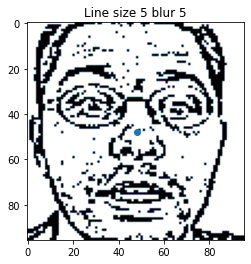

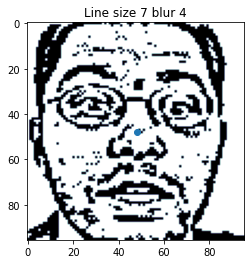

,X,y,shear,translation,rotation,scale
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[48, 48]",0,0,0,0
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[48, 48]",0,0,0,0


In [73]:
# Cartoon
augment = AugmentData(cartoon_prob=1)
augment.transform_img(test_data[0, :].reshape((96, 96)), np.array([48, 48]), create_flip=False, do_debug_plots=True)

# 4. Image Centering

In [3]:
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install face_recognition
!pip3 install mtcnn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=09b157d88250f01dc3765517c3afdd60324a17953fb5bba5a674e73a39438926
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
     |███████████████████████████

In [4]:
from skimage import transform
def affine_transform(img, translation=(0, 0), scale=1.0, rotation=0, shear=0):
    """

    :param img: Image in a 2D format
    :param translation: x and y shift translations
    :param scale: Image scaling value
    :param rotation: Degree of rotation
    :param shear: Amount of shear in degress
    :return:
    """

    # Find the transformation matrix for the image
    tform = transform.AffineTransform(
        scale=scale, rotation=np.deg2rad(rotation), translation=translation,
                                  shear=np.deg2rad(shear))

    # This is the inverse transformation
    new_img = transform.warp(img, tform.inverse)

    # Return the inverse function
    return new_img, tform.params.copy(), np.linalg.inv(tform.params), tform.inverse

In [7]:
import random
from mtcnn.mtcnn import MTCNN
from modules.transforms import warp

detector = MTCNN()
def _expand_dim(axis, width, max_dim, fraction=0.1, do_debug=False):

    # Total expansion should  be that fraction
    fraction = fraction/2

    #  Make the box wider to capture more features especially eye features at the edges
    x_offset = int(width * fraction)
    x_min = axis - x_offset
    x_min = 0 if x_min < 0 else x_min
    if do_debug:
        print('axis  old %d new %d ' % (axis, x_min))
    axis = x_min

    # Max width is limited by where x is and teh edge of the image
    # Say x is 7 and the image has width 96, the max width can only be 96 - 7 - 1= 88
    max_width = max_dim - x_min - 1
    new_width = width + 2 * x_offset
    if do_debug:
        print('Width old %d new %d' % (width, new_width))
    width = new_width
    width = max_width if width > max_width else width

    return axis, width

def center_and_scale_image(image, do_scale=True, pick_center_image=True, do_debug=False):
    """
    Center the face in the image. When multiple face are in the image then use the closest to the center

    :param image: 2D image
    :param do_scale: Whether to scale the image or not
    :param pick_center_image: If multiple faces pick one closest to center or 
                            pick largest area
    :param debug: Verbose printout or not
    :return:
    """

    do_debug = do_debug
    scaled_image = False

    # Make it a three channel image
    if np.max(image) <= 1:
        scaled_image = True
        # Convert it into a 0 to 255 image
        image = (image * 255).astype('uint8')
    image = np.stack((image, image, image), axis=-1)

    # Detect the face in the image
    faces = detector.detect_faces(image)
    print('%d|' % len(faces), end='')
    if random.random() < 1/200:
        print('')

    # This is the center of the image
    image_center = np.array([(image.shape[1]-1)/2, (image.shape[0]-1)/2])
    if do_debug:
        print('Image center %s' % str(image_center))

    # Find the largest face and return that
    parameters = None
    if pick_center_image:
      previous_dist = 96**2 + 96**2
    else:
      previous_dist = 0
    for face in faces:
        # One face
        x, y, width, height = face['box']

        # Sometimes the height and width are off in the image
        # we need to truncate it
        width = image.shape[1] - x - 1 if width > image.shape[1] - x - 1 else width
        height = image.shape[0] - y - 1 if height > image.shape[0] - y - 1 else height

        # Location of this face
        face_center = np.array([x + width/2, y + height/2])

        if pick_center_image:
          # Euclidean distance of this face from the image center
          dist = np.sum((face_center - image_center)**2)**0.5
          condition = dist < previous_dist
        else:
          # Area of the face in pixels
          dist = width * height
          condition = dist > previous_dist
        
        if do_debug:
          print('Boxes: X %d Y %d width %d height %d center %s dist %.2f' % 
                (x, y, width, height, str(face_center), dist))

        if condition:
            # Location of the image
            parameters = (x, y, width, height)
            previous_dist = dist

    if parameters is not None:
      # These are the parameters for the image
      x, y, width, height = parameters
    else:
      x, y, width, height = (0, 0, image.shape[1]-1, image.shape[0]-1)

    # Expand the axis in the x dimension
    x, width = _expand_dim(x, width, image.shape[1], fraction=0.15, do_debug=do_debug)
    y, height = _expand_dim(y, height, image.shape[0], fraction=0.15, do_debug=do_debug)
    # This is the scale the image can be scaled by before exceeding image size
    scaling = (image.shape[0]-1) / max(width, height)

    image = np.squeeze(image[:, :, 0])
    if scaled_image:
        image = image.astype('float32')/255
    
    if not do_scale:
      # 
      scaling = 1
      center_x =  (image_center[0] - (x + width/2))*scaling
      center_y =  (image_center[1] - (y + height/2))*scaling
    else:
      # Shift must be to get 0,0 to the left most
      center_x = -x*scaling
      center_y = -y*scaling

    if do_debug:
        print('X %d Y %d width %d height %d scaling %.2f' % (x, y, width, height, scaling))

    if do_debug:
        print('Center X %.2f Y %.2f' % (center_x, center_y))

    # This is the translated image
    new_img, forward, inverse, inv_func = affine_transform(image, (center_x, center_y), (scaling, scaling))

    if do_debug:
      print('Forward %s' % str(forward))
      print('Inverse %s' % str(inverse))

    if not do_scale:
      # If the image is not scaled then make the area outside the face as 0's
      zero_padded = np.zeros(new_img.shape)
      x_min = int(image_center[0]-width/2)
      x_max = int(image_center[0]+width/2+1)
      y_min = int(image_center[1]-height/2)
      y_max = int(image_center[1]+height/2+1)
      if do_debug:
        print('x_min %d x_max %d y_min %d y_max %d' % 
              (x_min, x_max, y_min, y_max))
      zero_padded[x_min:x_max, y_min:y_max] = new_img[x_min:x_max, y_min:y_max]
    else:
      zero_padded = new_img
      
    return zero_padded, forward, inverse, (x, y, width, height), inv_func
  
def center_image_plots(data, index_list=None, prefix='', do_scale=True, 
                       pick_center_image=True):
  # index_list = [6765, ]
  data = data.reset_index()

  if index_list is None:
    index_list = list(range(data.shape[0]))

  for index in index_list:
    # Coordinates in the original image
    orig_img = data.iloc[index]['orig_Image']
    new_img, forward, inverse, location, inv_func = \
      center_and_scale_image(orig_img, do_scale=do_scale,  
                             pick_center_image=pick_center_image)
    
    # Center of the box
    coord = np.array((location[0] + location[2]/2, location[1] + location[3]/2))
    new_coord = warp(forward, coord)

    # 
    coord_trans = (48, 48)
    coord_inv = warp(inverse, coord_trans)

    # Center the original image and its corresponding landmark
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img, cmap='bone')
    plt.plot(coord[0], coord[1], marker='o', color='g')
    plt.plot(coord_inv[0], coord_inv[1], marker='x', color='y')
    rect = plt.Rectangle((location[0], location[1]), location[2], location[3], 
                         fill=False, color='orange')
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title('Original image and landmark')

    plt.subplot(1, 2, 2)
    plt.imshow(new_img, cmap='bone')
    if 0 < new_coord[0] < 96 and 0 < new_coord[1] < 96:
      plt.plot(new_coord[0], new_coord[1], marker='x', color='g')

    plt.plot(coord_trans[0], coord_trans[1], marker='o', color='y')
    plt.title('Detected Face')
    plt.suptitle('index %d x %d y %d width %d height %d' % (index, *location))
    filename = 'data/analysis/centering/%s_index_%d.png' % (prefix, index)
    plt.savefig(filename)

In [9]:
sd = SourceData(debug=True)

# all_data = source_all_data_csv()
submission_data = sd.source_test_csv()
submission_data.reset_index(inplace=True)

Preprocessing submission data


2|

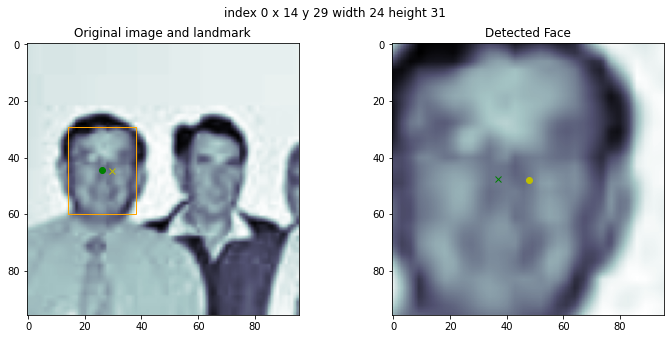

In [12]:
center_image_plots(submission_data[submission_data['ImageId']==951], None, 'test', do_scale=True, pick_center_image=False)

In [ ]:
center_image_plots(submission_data[submission_data['ImageId']==782], None, 'test', do_scale=True, pick_center_image=False)

# Inconistent landmarks

In [13]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
filename = 'data/processed_data.p'
with open(filename, 'rb') as infi:
  transformed = pickle.load(infi)

In [18]:
def plot_samples(indata, response_names=None):
    """

    :param indata:
    :return:
    """

    if response_names is None:
      response_columns = ['left_eyebrow_outer_end', 'right_eye_outer_corner', 'right_eye_inner_corner',
                          'left_eye_inner_corner', 'mouth_right_corner', 'mouth_left_corner',
                          'right_eyebrow_outer_end', 'left_eyebrow_inner_end', 'mouth_center_top_lip',
                          'right_eyebrow_inner_end', 'left_eye_outer_corner',
                          'mouth_center_bottom_lip', 'nose_tip', 'right_eye_center', 
                          'left_eye_center']
    else:
      response_columns = response_names

    # Where are all the NAN's in the data?
    nans = None
    for response in response_columns:
        tmp = indata[response].apply(lambda x1: np.any(np.isnan(x1))).values
        if tmp is None:
            nans = tmp
        else:
            nans = np.logical_or(nans, tmp)

    # Not nans
    # not_nans = np.logical_not(nans)
    # filtered = indata[not_nans].copy()
    filtered = indata
    filtered.reset_index(inplace=True, drop=True)
    for index in range(filtered.shape[0]):
        #
        plt.figure(figsize=(6.4*2, 4.8*10))
        plt.subplot(1, 2, 1)
        # index = random.randint(0, filtered.shape[0]-1)
        plt.imshow(filtered.iloc[index]['orig_Image'], cmap='bone')
        plt.title('Original image: %d' % filtered.iloc[index]['unique_id'])
        for response in response_columns:
            if response in filtered.columns:
                x = [filtered.iloc[index][response][0], ]
                y = [filtered.iloc[index][response][1], ]
                if not np.isnan(x) and not np.isnan(y):
                  plt.plot(x, y, marker='o', markersize=3, color='r')

        #
        plt.subplot(1, 2, 2)
        plt.imshow(filtered.iloc[index]['X'], cmap='bone')
        plt.title('Pre-processed image')
        for response in response_columns:
            if response in filtered.columns:
                x = [filtered.iloc[index][response + '_t'][0], ]
                y = [filtered.iloc[index][response + '_t'][1], ]
                if not np.isnan(x) and not np.isnan(y):
                  plt.plot(x, y, marker='o', markersize=3, color='r')
        
        if index == 50:
          break
    # filename = 'data/cv_check/processed_data.p'
    plt.show()

In [19]:
plot_samples(transformed['cv'])

Output hidden; open in https://colab.research.google.com to view.